In [23]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [24]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [25]:
NUM_CLASSES = 6

# 学習データ読み込み

In [26]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [27]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [30]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1136 (4.44 KB)
Trainable params: 1136 (4.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [32]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [33]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


30/36 [========================>.....] - ETA: 0s - loss: 1.8819 - accuracy: 0.1456 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
36/36 [==============================] - 1s 8ms/step - loss: 1.8716 - accuracy: 0.1515 - val_loss: 1.7734 - val_accuracy: 0.2652
Epoch 2/1000
26/36 [====================>.........] - ETA: 0s - loss: 1.7808 - accuracy: 0.2320
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
36/36 [==============================] - 0s 4ms/step - loss: 1.7740 - accuracy: 0.2410 - val_loss: 1.7210 - val_accuracy: 0.3674
Epoch 3/1000
 1/36 [..............................] - ETA: 0s - loss: 1.7378 - accuracy: 0.2969

/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/36 [================>.............] - ETA: 0s - loss: 1.7434 - accuracy: 0.2723
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
36/36 [==============================] - 0s 4ms/step - loss: 1.7251 - accuracy: 0.2961 - val_loss: 1.6543 - val_accuracy: 0.3607
Epoch 4/1000
25/36 [===================>..........] - ETA: 0s - loss: 1.6794 - accuracy: 0.3272
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
36/36 [==============================] - 0s 4ms/step - loss: 1.6717 - accuracy: 0.3386 - val_loss: 1.5536 - val_accuracy: 0.4596
Epoch 5/1000
25/36 [===================>..........] - ETA: 0s - loss: 1.6185 - accuracy: 0.3694
Epoch 5: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
36/36 [==============================] - 0s 4ms/step - loss: 1.6054 - accuracy: 0.3740 - val_loss: 1.4429 - val_accuracy: 0.5104
Epoch 6/1000
26/36 [====================>.........] - ETA: 0s - loss: 1.5555 - accuracy: 0.3855
Epoch 6: savin

In [34]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

12/12 [==============================] - 0s 3ms/step - loss: 0.3246 - accuracy: 0.9472


In [35]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [36]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 71ms/step
[0.03041605 0.02234123 0.00741564 0.34492698 0.00259885 0.5923013 ]
5


# 混同行列

47/47 [==============================] - 0s 3ms/step


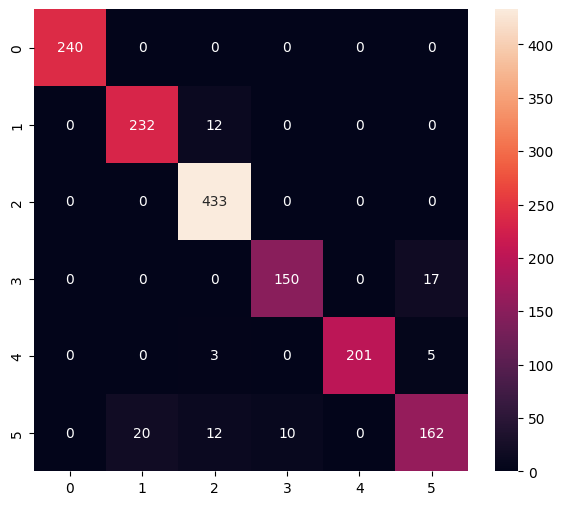

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       0.92      0.95      0.94       244
           2       0.94      1.00      0.97       433
           3       0.94      0.90      0.92       167
           4       1.00      0.96      0.98       209
           5       0.88      0.79      0.84       204

    accuracy                           0.95      1497
   macro avg       0.95      0.93      0.94      1497
weighted avg       0.95      0.95      0.95      1497



In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [38]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_3.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpues7ugsi/assets


INFO:tensorflow:Assets written to: /tmp/tmpues7ugsi/assets
2024-01-11 09:39:10.574701: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-11 09:39:10.574723: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-11 09:39:10.574892: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpues7ugsi
2024-01-11 09:39:10.576081: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-11 09:39:10.576092: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpues7ugsi
2024-01-11 09:39:10.581327: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-11 09:39:10.623288: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpues7ugsi
2024-01-11 09:39:10.638215: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

6660

# 推論テスト

In [40]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [41]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [42]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [43]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 772 µs, sys: 62 µs, total: 834 µs
Wall time: 771 µs


In [44]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.03041604 0.02234122 0.00741563 0.34492692 0.00259884 0.5923013 ]
5
